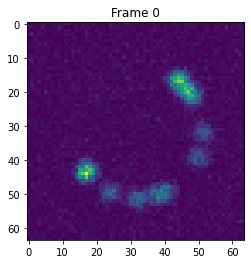

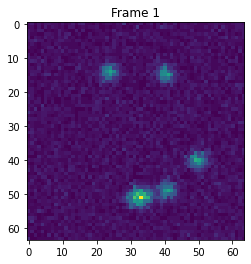

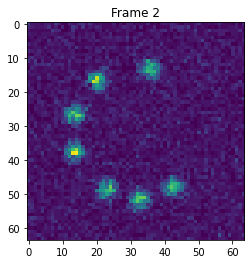

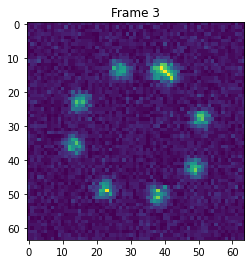

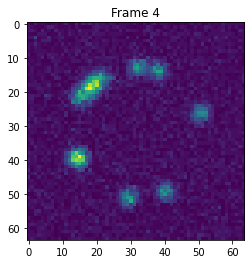

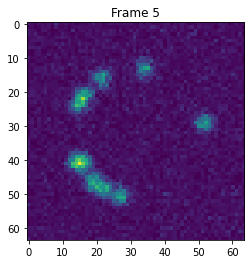

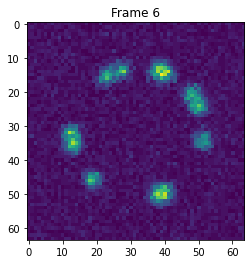

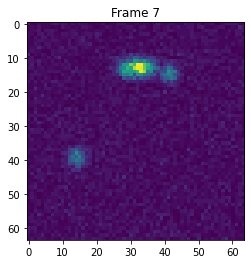

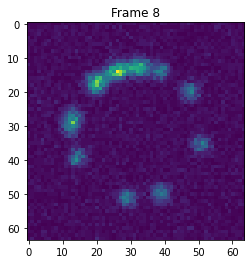

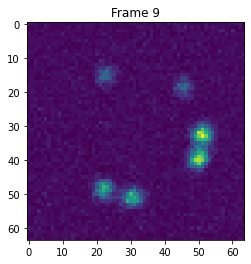

Maxfiltersize: 9
Time: 1.768275260925293 s. 5.65522813160167 fps. numspots=66
Fitted results (66):
[[4.55026779e+01 1.82890759e+01 1.36571179e+03 9.59761906e+00]
 [5.13438568e+01 3.20127563e+01 4.20781158e+02 2.44963908e+00]
 [4.99094505e+01 3.90434341e+01 3.92589966e+02 3.28039145e+00]
 [1.69956703e+01 4.34707031e+01 1.37925073e+03 1.83319914e+00]
 [2.39565620e+01 4.94748497e+01 4.15015167e+02 3.27154088e+00]
 [3.85524940e+01 4.99198456e+01 7.43127014e+02 4.57960653e+00]
 [3.28055763e+01 5.11938171e+01 5.23063416e+02 3.71706414e+00]
 [2.36361523e+01 1.42856054e+01 4.97919434e+02 1.27953362e+00]
 [4.01139755e+01 1.47954407e+01 4.61712006e+02 1.55926633e+00]
 [4.96464577e+01 4.00635300e+01 5.18002136e+02 1.44958985e+00]
 [4.02653618e+01 4.90970726e+01 4.47317017e+02 2.81938100e+00]
 [3.26257706e+01 5.09005165e+01 8.75018127e+02 2.65660930e+00]
 [3.57757416e+01 1.33836155e+01 4.67870880e+02 2.02363062e+00]
 [2.02010765e+01 1.66883888e+01 5.23660278e+02 1.38147771e+00]
 [1.36417179e+01 2.

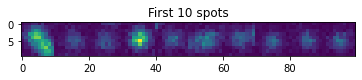

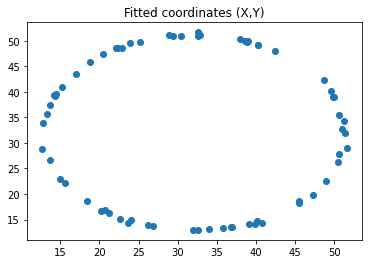

In [1]:
"""
Spot detection + fitting example 
"""
import numpy as np
import matplotlib.pyplot as plt
from photonpy.cpp.gaussian import Gaussian
from photonpy.cpp.context import Context
import photonpy.cpp.spotdetect as spotdetect
import photonpy.smlm.util as smlmutil
import math
import time
import tqdm


def generate_storm_movie(gaussian, emitterList, numframes=100, imgsize=512, intensity=500, bg=2, sigma=1.5, p_on=0.1):
    frames = np.zeros((numframes, imgsize, imgsize), dtype=np.uint16)
    emitters = np.array([[e[0], e[1], sigma, sigma, intensity] for e in emitterList])

    on_counts = np.zeros(numframes, dtype=np.int32)

    for f in range(numframes):
        frame = bg * np.ones((imgsize, imgsize), dtype=np.float32)
        frame_emitters = emitters * 1
        on = np.random.binomial(1, p_on, len(emitters))
        frame_emitters[:, 4] *= on

        frame = gaussian.Draw(frame, frame_emitters)
        frames[f] = frame
        on_counts[f] = np.sum(on)

    return frames, on_counts


psfSigma = 1.8
roisize = 10
w = 64
N = 2000
numframes = 10
R = np.random.normal(0, 0.2, size=N) + w * 0.3
angle = np.random.uniform(0, 2 * math.pi, N)
emitters = np.vstack((R * np.cos(angle) + w / 2, R * np.sin(angle) + w / 2)).T


with Context() as ctx:
    gaussian = Gaussian(ctx)
    mov, on_counts= generate_storm_movie(gaussian, emitters, numframes, imgsize=w, sigma=psfSigma, p_on=10 / N)
    mov = np.random.poisson(mov)
    
    plt.figure()
    for i in range(len(mov)):
        plt.imshow(mov[i])
        plt.title(f'Frame {i}')
        plt.pause(0.5)
        

    spotDetector = spotdetect.SpotDetector(psfSigma, roisize, minIntensity=1.5)
    print(f"Maxfiltersize: {spotDetector.maxFilterSize}")
    spotDetector.maxFilterSize = int(psfSigma*5) # adjust to detect spots closer together (default int(sigma*5))

    processFrame = spotdetect.SpotDetectionMethods(ctx).ProcessFrame

    numspots=0
    t0 = time.time()
    allrois = []
    allcornerpos = []
    for f in range(len(mov)):
        rois, cornerpos, scores,_ = processFrame(mov[f], spotDetector,
                                               roisize=10,maxSpotsPerFrame= 100)
        
        allrois.append(rois)
        allcornerpos.append(cornerpos)
        
    allrois = np.concatenate(allrois)
    allcornerpos = np.concatenate(allcornerpos)

    t1 = time.time()
    
    print(f"Time: {t1-t0} s. {len(mov)/(t1-t0)} fps. numspots={len(allrois)}")
    smlmutil.imshow_hstack(allrois)
    plt.title('First 10 spots')
    
    psf = gaussian.CreatePSF_XYIBg(roisize, psfSigma, True)
    
    results, diag, traces = psf.Estimate(allrois)
    
    # ROI coordinates use python indexing (y,x)
    results[:,0] += allcornerpos[:,1]
    results[:,1] += allcornerpos[:,0]
    
    print(f"Fitted results ({len(results)}):")
    print(results)
    
    plt.figure()
    plt.scatter(results[:,0],results[:,1])
    plt.title('Fitted coordinates (X,Y)')
    
    